Import stuff

In [45]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np

#pv.set_jupyter_backend("ipyvtklink")

# convert mesh to pv_mesh
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh

Import Envelope Lattice/streetnetwork

In [46]:
# loading the lattice from csv
lattice_path = os.path.relpath('../data/meshes/voxelized_envelope_highres.csv')
envelope_lattice = tg.lattice_from_csv(lattice_path)
envelope_lattice.shape

env_cens = envelope_lattice.centroids_threshold(-1)

print (env_cens)

# import the streetnetwork as a point cloud (workshop file, temporary)
street_path = os.path.relpath("../data/meshes/street_points.csv")
street_pc = tg.cloud_from_csv(street_path)

print (street_pc)


#importing the context mesh

context_path = os.path.relpath('../data/meshes/immediate_context.obj')
context_mesh = tm.load(context_path)

[[ -40. -100.    0.]
 [ -40. -100.    5.]
 [ -40. -100.   10.]
 ...
 [ 110.  -15.   25.]
 [ 110.  -15.   30.]
 [ 110.  -15.   35.]]
[[ -50. -110.    0.]
 [ -49. -110.    0.]
 [ -48. -110.    0.]
 ...
 [ 120.   -8.    0.]
 [ 120.   -7.    0.]
 [ 120.   -6.    0.]]


Calculate euclidean distance between voxels and the street

In [47]:
# extracting the centroid of all voxels
env_cens = envelope_lattice.centroids_threshold(-1)
#print(env_cens.size)
# initializing the distance matrix
dist_m = []
# for each voxel ...
for voxel_cen in env_cens:
    # initializing the distance vector (per each voxel)
    dist_v = []
    # for each street point ...
    for street_point in street_pc:
        # find the difference vector
        diff = voxel_cen - street_point
        # raise the components to the power of two
        diff_p2 = diff**2
        # sum the components
        diff_p2s = diff_p2.sum()
        # compute the square root 
        dist = diff_p2s**0.5
        # add the distance to the distance vector
        dist_v.append(dist)
    # add the distance vector to the distance matrix
    dist_m.append(dist_v)
# change the distance matrix type, from list to array
dist_m = np.array(dist_m)
#print(dist_m.size, dist_m.shape)

# find the distance to the closest street point for each voxel
min_dist = dist_m.min(axis=1)

np_lat = np.array(env_cens)

# convert the minimum distance list to a lattice
min_dist_array = min_dist.reshape(envelope_lattice.shape)
min_dist_lat = tg.to_lattice(min_dist_array, envelope_lattice)

# zero the value of the exterior voxels
envelope_eu_dist_lattice = min_dist_lat * envelope_lattice


Saving the eucledean distance between voxels and street points (min_dist_lat)

In [48]:
min_dist_lat.to_csv('../data/fields/euclidean_distance.csv')

Plotting

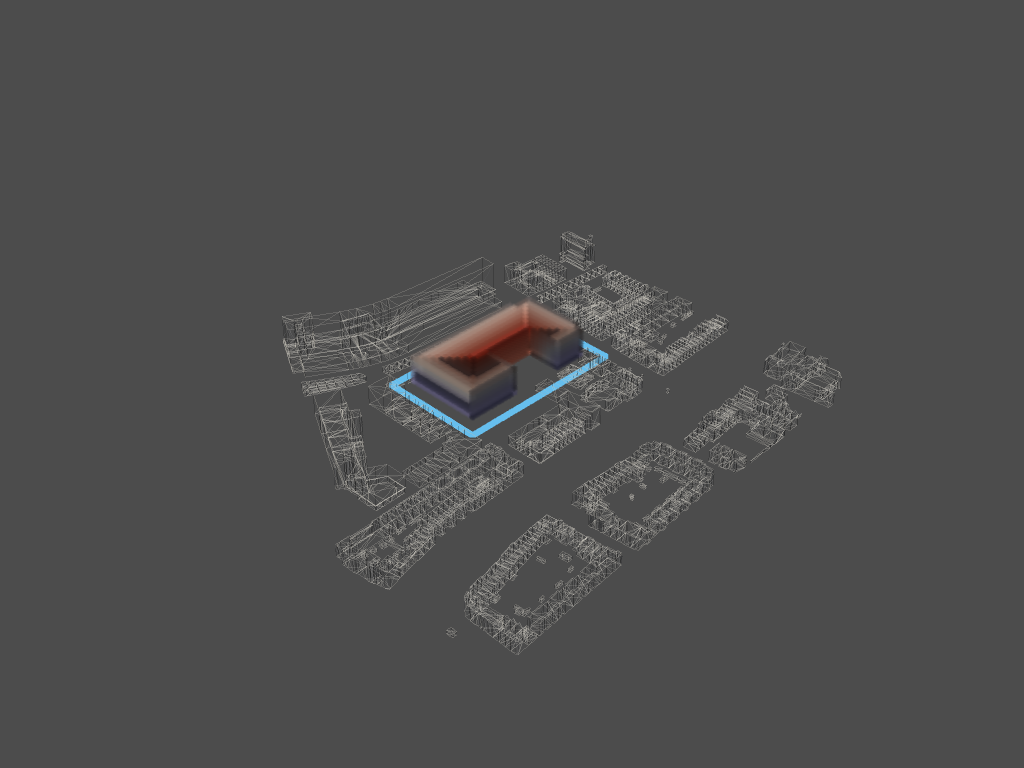

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [49]:
# initiating the plotter
p = pv.Plotter()

l = envelope_eu_dist_lattice * envelope_lattice

# remapping
l = 250 * (l - l.min()) / l.max()

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Distance"] = l.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# fast visualization of the point cloud
street_pc.fast_notebook_vis(p)

# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6]) * 1.5
p.add_volume(grid, cmap="coolwarm", opacity=opacity, shade=True, show_scalar_bar=False)

# plotting
p.show()

Calculating the actual loudness level that is caused by the street

In [50]:
str_loud_lev = 73.4 #dB(a)

#calculating the actual loudness level
# act_loud_lev = ((1 / min_dist_lat) **2) * str_loud_lev

act_loud_lev = str_loud_lev - (10 * np.log10((2 * np.pi * min_dist_lat) / 2))

# convert the minimum distance list to a lattice
min_loud_array = act_loud_lev.reshape(envelope_lattice.shape)
min_loud_lat = tg.to_lattice(min_loud_array, envelope_lattice)

# zero the value of the exterior voxels
envelope_eu_loud_lattice = min_loud_lat * envelope_lattice



Calculate the eucledean distance between the voxels and the football field

Calculate the noise that is caused by the football field

Calculate the loudness level per voxel

Calculate the relative loudness level

In [51]:
print(act_loud_lev)

[[[58.42850127 57.94395121 56.92335129 ... 54.12681124 53.42850127
   52.81742188]
  [58.42850127 57.94395121 56.92335129 ... 54.12681124 53.42850127
   52.81742188]
  [58.42850127 57.94395121 56.92335129 ... 54.12681124 53.42850127
   52.81742188]
  ...
  [58.42850127 57.94395121 56.92335129 ... 54.12681124 53.42850127
   52.81742188]
  [58.42850127 57.94395121 56.92335129 ... 54.12681124 53.42850127
   52.81742188]
  [58.42850127 57.94395121 56.92335129 ... 54.12681124 53.42850127
   52.81742188]]

 [[58.42850127 57.94395121 56.92335129 ... 54.12681124 53.42850127
   52.81742188]
  [56.66758868 56.43880123 55.86908447 ... 53.78140664 53.17273866
   52.62166126]
  [56.66758868 56.43880123 55.86908447 ... 53.78140664 53.17273866
   52.62166126]
  ...
  [56.66758868 56.43880123 55.86908447 ... 53.78140664 53.17273866
   52.62166126]
  [56.66758868 56.43880123 55.86908447 ... 53.78140664 53.17273866
   52.62166126]
  [58.42850127 57.94395121 56.92335129 ... 54.12681124 53.42850127
   52.

In [60]:
#act_loud_lev

rel_loud_lev = 1 / act_loud_lev
rel_loud_lev2 = 1 - rel_loud_lev

print(rel_loud_lev2)

[[[0.98288507 0.98274194 0.98243252 ... 0.98152487 0.9812834  0.98106685]
  [0.98288507 0.98274194 0.98243252 ... 0.98152487 0.9812834  0.98106685]
  [0.98288507 0.98274194 0.98243252 ... 0.98152487 0.9812834  0.98106685]
  ...
  [0.98288507 0.98274194 0.98243252 ... 0.98152487 0.9812834  0.98106685]
  [0.98288507 0.98274194 0.98243252 ... 0.98152487 0.9812834  0.98106685]
  [0.98288507 0.98274194 0.98243252 ... 0.98152487 0.9812834  0.98106685]]

 [[0.98288507 0.98274194 0.98243252 ... 0.98152487 0.9812834  0.98106685]
  [0.98235323 0.98228169 0.98210101 ... 0.98140621 0.98119337 0.98099642]
  [0.98235323 0.98228169 0.98210101 ... 0.98140621 0.98119337 0.98099642]
  ...
  [0.98235323 0.98228169 0.98210101 ... 0.98140621 0.98119337 0.98099642]
  [0.98235323 0.98228169 0.98210101 ... 0.98140621 0.98119337 0.98099642]
  [0.98288507 0.98274194 0.98243252 ... 0.98152487 0.9812834  0.98106685]]

 [[0.98288507 0.98274194 0.98243252 ... 0.98152487 0.9812834  0.98106685]
  [0.98235323 0.982281

Plotting the actual loudness level (work in progress)

In [53]:
# initiating the plotter
p = pv.Plotter()

l = envelope_eu_loud_lattice * envelope_lattice

# remapping
l = 250 * (l - l.min()) / l.max()

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Distance"] = l.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# fast visualization of the point cloud
street_pc.fast_notebook_vis(p)

# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6]) * 1.5
p.add_volume(grid, cmap="coolwarm", opacity=opacity, shade=True, show_scalar_bar=False)

# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

saving the actual loudness level (work in progress)

In [54]:
act_loud_lev.to_csv('../data/fields/actual_loudness_level.csv')

Save the relative loudness

In [62]:
rel_loud_lev.to_csv('../data/fields/noise_approval.csv')